In [1]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [2]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import vmap


from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import DiagonalGaussianHMM
from dynamax.hidden_markov_model import SphericalGaussianHMM
from dynamax.hidden_markov_model import SharedCovarianceGaussianHMM
from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
# Helper functions for plotting
def plot_gaussian_hmm(hmm, params, emissions, states,  title="Emission Distributions", alpha=0.25):
    lim = 1.1 * abs(emissions).max()
    XX, YY = jnp.meshgrid(jnp.linspace(-lim, lim, 100), jnp.linspace(-lim, lim, 100))
    grid = jnp.column_stack((XX.ravel(), YY.ravel()))

    plt.figure()
    for k in range(hmm.num_states):
        lls = hmm.emission_distribution(params, k).log_prob(grid)
        plt.contour(XX, YY, jnp.exp(lls).reshape(XX.shape), cmap=white_to_color_cmap(COLORS[k]))
        plt.plot(emissions[states == k, 0], emissions[states == k, 1], "o", mfc=COLORS[k], mec="none", ms=3, alpha=alpha)

    plt.plot(emissions[:, 0], emissions[:, 1], "-k", lw=1, alpha=alpha)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title(title)
    plt.gca().set_aspect(1.0)
    plt.tight_layout()


def plot_gaussian_hmm_data(hmm, params, emissions, states, xlim=None):
    num_timesteps = len(emissions)
    emission_dim = hmm.emission_dim
    means = params.emissions.means[states]
    lim = 1.05 * abs(emissions).max()

    # Plot the data superimposed on the generating state sequence
    fig, axs = plt.subplots(emission_dim, 1, sharex=True)
    
    for d in range(emission_dim):    
        axs[d].imshow(states[None, :], aspect="auto", interpolation="none", cmap=CMAP,
                      vmin=0, vmax=len(COLORS) - 1, extent=(0, num_timesteps, -lim, lim))
        axs[d].plot(emissions[:, d], "-k")
        axs[d].plot(means[:, d], ":k")
        axs[d].set_ylabel("$y_{{t,{} }}$".format(d+1))
        
    if xlim is None:
        plt.xlim(0, num_timesteps)
    else:
        plt.xlim(xlim)

    axs[-1].set_xlabel("time")
    axs[0].set_title("Simulated data from an HMM")
    plt.tight_layout()

In [4]:
num_train_batches = 3
num_test_batches = 1
num_timesteps = 100

# Make an HMM and sample data and true underlying states
true_num_states = 5
emission_dim = 2
hmm = GaussianHMM(true_num_states, emission_dim)

# Specify parameters of the HMM
initial_probs = jnp.ones(true_num_states) / true_num_states
transition_matrix = 0.80 * jnp.eye(true_num_states) \
    + 0.15 * jnp.roll(jnp.eye(true_num_states), 1, axis=1) \
    + 0.05 / true_num_states
emission_means = jnp.column_stack([
    jnp.cos(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.sin(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.zeros((true_num_states, emission_dim - 2)),
    ])
emission_covs = jnp.tile(0.1**2 * jnp.eye(emission_dim), (true_num_states, 1, 1))
        
true_params, _ = hmm.initialize(initial_probs=initial_probs,
                                transition_matrix=transition_matrix,
                                emission_means=emission_means,
                                emission_covariances=emission_covs)

# Sample train, validation, and test data
train_key, val_key, test_key = jr.split(jr.PRNGKey(0), 3)
f = vmap(partial(hmm.sample, true_params, num_timesteps=num_timesteps))
train_true_states, train_emissions = f(jr.split(train_key, num_train_batches))
test_true_states,  test_emissions  = f(jr.split(test_key, num_test_batches))

In [44]:
jnp.shape(train_true_states)

(3, 100)

In [7]:
jnp.shape(train_emissions)

(3, 100, 2)

In [46]:
part1, part2, part3 = jnp.split(train_emissions, 3)
jnp.shape(jnp.concatenate([part1, part2, part3]))

In [48]:
jnp.shape(jnp.concatenate([part1, part2, part3]))

(3, 100, 2)

In [10]:
def cross_validate_model(model, key, num_iters=100):
    # Initialize the parameters using K-Means on the full training set
    params, props = model.initialize(key=key, method="kmeans", emissions=train_emissions)
    
    # Split the training data into folds.
    # Note: this is memory inefficient but it highlights the use of vmap.
    folds = jnp.stack([
        jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
        for i in range(num_train_batches)
    ])
    
    def _fit_fold(y_train, y_val):
        fit_params, train_lps = model.fit_em(params, props, y_train, 
                                             num_iters=num_iters, verbose=False)
        return model.marginal_log_prob(fit_params, y_val)

    val_lls = vmap(_fit_fold)(folds, train_emissions)
    return val_lls.mean(), val_lls

In [15]:
model = test_hmm
key = jr.PRNGKey(0)
num_iters = 100
params, props = model.initialize(key=key, method="kmeans", emissions=train_emissions)

# Split the training data into folds.
# Note: this is memory inefficient but it highlights the use of vmap.
folds = jnp.stack([
    jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
    for i in range(num_train_batches)
])

def _fit_fold(y_train, y_val):
    fit_params, train_lps = model.fit_em(params, props, y_train, 
                                            num_iters=num_iters, verbose=False)
    return model.marginal_log_prob(fit_params, y_val)

val_lls = vmap(_fit_fold)(folds, train_emissions)

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [24]:
folds = jnp.stack([
    jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
    for i in range(num_train_batches)
])

In [30]:
for i in range(num_train_batches):
    print(i)

0
1
2


In [39]:
i = 0
a = jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
i = 1
b = jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
i = 2
c = jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
print(jnp.shape(a), jnp.shape(b), jnp.shape(c))
#jnp.shape(train_emissions[i+1:])

(2, 100, 2) (2, 100, 2) (2, 100, 2)


In [41]:
d = jnp.stack([a, b, c])
jnp.shape(d)

(3, 2, 100, 2)

In [29]:
[jnp.concatenate([train_emissions[:i], train_emissions[i+1:]]) for i in range(num_train_batches)]

[Array([[[ 0.93211055,  0.06626474],
         [ 0.35017994,  0.97471905],
         [-0.8109385 ,  0.54205   ],
         [-0.8012039 ,  0.6453685 ],
         [-0.755138  ,  0.69244266],
         [-0.6351679 ,  0.5151794 ],
         [-0.76603794,  0.5720403 ],
         [-0.7514261 , -0.6287814 ],
         [ 0.38578454, -1.0370821 ],
         [ 0.3504242 , -0.8789102 ],
         [ 0.17925929, -1.0578153 ],
         [ 0.36537975, -0.9969282 ],
         [ 0.20039067, -0.87923425],
         [ 0.34627926, -0.94474506],
         [ 0.45466286, -0.96497643],
         [ 0.3875742 , -0.9984174 ],
         [ 0.26486984, -0.96910775],
         [ 0.9818261 ,  0.0320369 ],
         [ 1.1291256 ,  0.13564382],
         [ 0.8702247 , -0.07361229],
         [ 0.9677579 , -0.0458537 ],
         [ 0.91111296,  0.17230994],
         [ 0.897957  , -0.0236588 ],
         [ 1.0202469 ,  0.07492431],
         [ 0.33328336,  0.97135323],
         [ 0.31660646,  0.9101343 ],
         [ 0.45949015,  0.93974507],
 

In [25]:
jnp.shape(folds)

(3, 2, 100, 2)

In [11]:
# Make a range of Gaussian HMMs
all_num_states = list(range(2, 10))
test_hmms = [GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.) 
          for num_states in all_num_states]
results = []
for test_hmm in test_hmms:
    print(f"fitting model with {test_hmm.num_states} states")
    results.append(cross_validate_model(test_hmm, jr.PRNGKey(0)))
    
avg_val_lls, all_val_lls = tuple(zip(*results))

fitting model with 2 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 5 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 6 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 7 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 8 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 9 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0, 0.5, 'avg. validation log prob.')

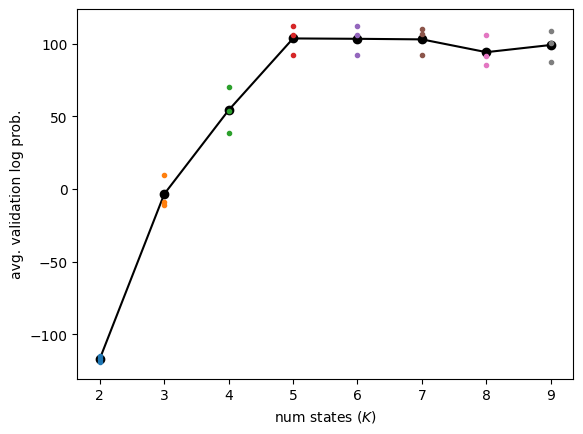

In [12]:
plt.plot(all_num_states, avg_val_lls, '-ko')
for k, per_fold_val_lls in zip(all_num_states, all_val_lls):
    plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
plt.xlabel("num states ($K$)")
plt.ylabel("avg. validation log prob.")

In [ ]:
one = ONE()
example_session = 'cb2ad999-a6cb-42ff-bf71-1774c57e5308'

# Trials data
session_trials = one.load_object(example_session, obj='trials', namespace='ibl')
session_trials = session_trials.to_df()

# Licks
session_licks = get_lick_times(example_session, video_type = 'left')

# Wheel
wheel = one.load_object(example_session, 'wheel', collection='alf')
pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)



(-10.0, 10.0)

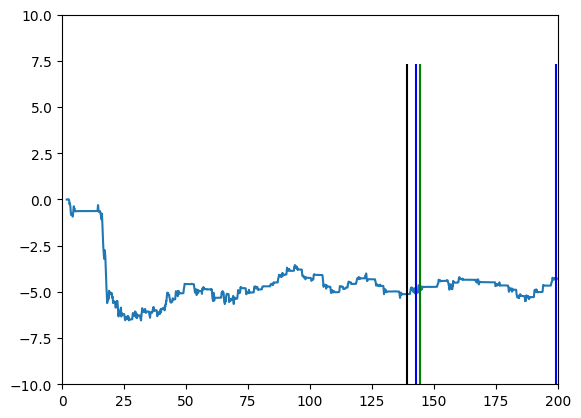

In [ ]:
plt.plot(wheel_times, pos)
plt.vlines(np.array(session_trials['goCue_times'] * 10), np.min(test_set) -.5, np.max(test_set) + .5, label='Stim On', color='Black')
plt.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 10), np.min(test_set) -.5, np.max(test_set) + .5, label='Correct', color='Green')
plt.vlines(np.array(session_trials.loc[session_trials['feedbackType']==0, 'feedback_times'] * 10), np.min(test_set) -.5, np.max(test_set) + .5, label='Incorrect', color='Red')
plt.vlines(np.array(session_trials['firstMovement_times'] * 10), np.min(test_set) -.5, np.max(test_set) + .5, label='First movement', color='Blue')
plt.xlim([000, 200])
plt.ylim([-10, 10])

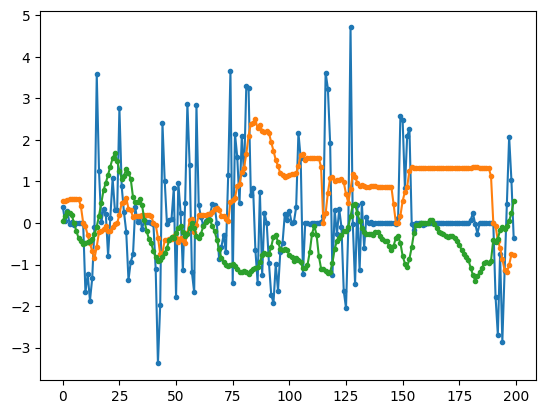

In [ ]:
plt.plot(test_set[200:400, :] , '-', marker='.')

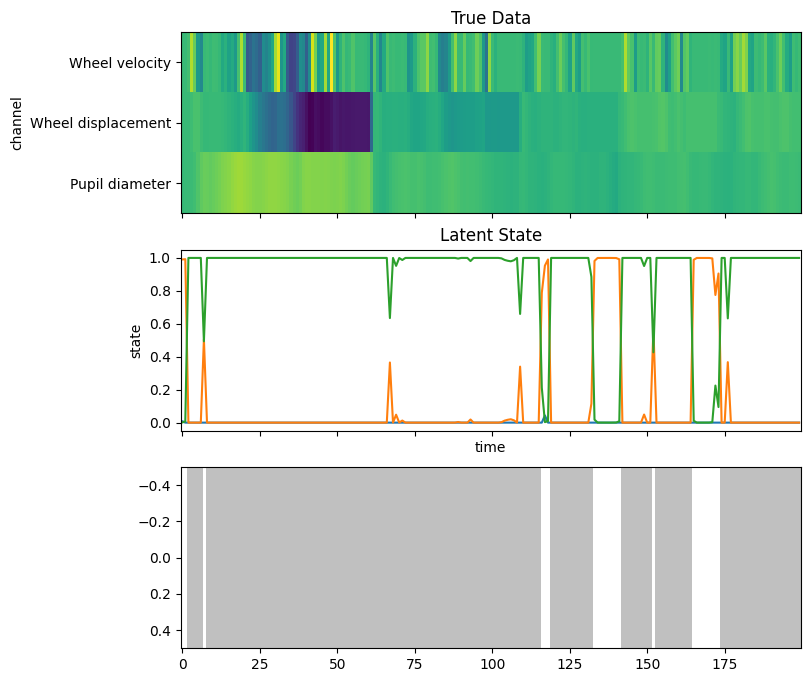

In [ ]:
# Posterior distribution
posterior = test_hmm.smoother(params, standardized_matrix[0:200])
Ez = posterior.smoothed_probs

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 8))
axs[0].imshow(standardized_matrix[0:200].T, aspect="auto", interpolation="none")
axs[0].set_ylabel("channel")
axs[0].set_title("True Data")
axs[1].plot(Ez)
axs[2].imshow(
    most_likely_states[None, 0:200],
    aspect="auto",
    cmap="Greys",
    alpha=0.25)
axs[1].set_title("Latent State")
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")

axs[0].set_yticks([0, 1, 2], ['Wheel velocity', 'Wheel displacement', 'Pupil diameter'])
plt.show()



In [ ]:
most_likely_states[None, :]

Array([[1, 1, 2, ..., 2, 2, 2]], dtype=int32)

Text(0, 0.5, 'log likelihood')

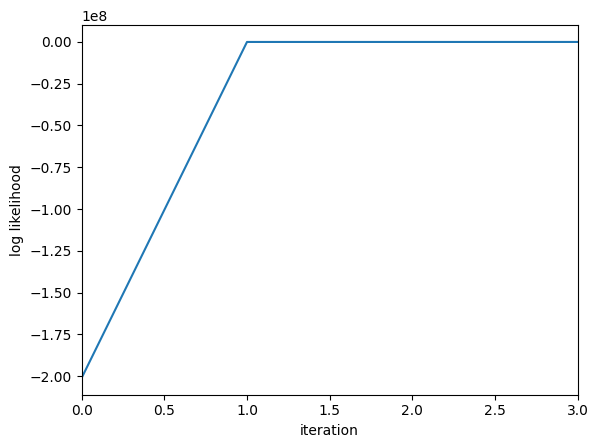

In [ ]:
# Plot the log probabilities
plt.plot(lps)
plt.xlim([0,3])
plt.xlabel("iteration")
plt.ylabel("log likelihood")

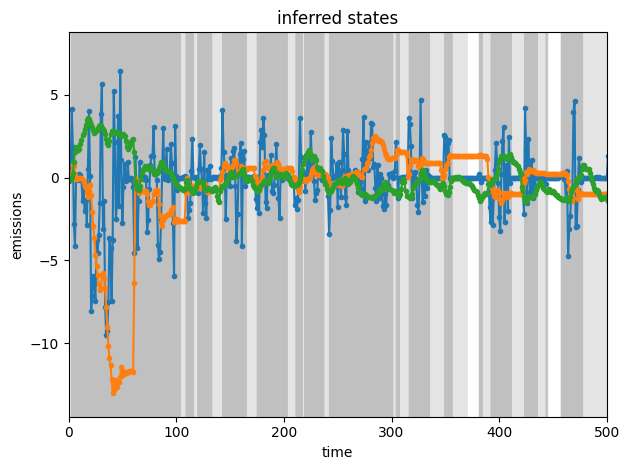

In [ ]:
# Compute the most likely states
most_likely_states = test_hmm.most_likely_states(params, standardized_matrix)

# Compare them to the true states
fig, axs = plt.subplots(1, 1, sharex=True)

for i, states in enumerate([most_likely_states]):
    offsets = 3 * jnp.arange(emission_dim)
    axs.imshow(
        states[None, :],
        extent=(0, num_timesteps, np.min(standardized_matrix) -.5, np.max(standardized_matrix) + .5),
        aspect="auto",
        cmap="Greys",
        alpha=0.25)
    #axs.plot(standardized_matrix + offsets, '-', marker='.')
    axs.plot(standardized_matrix , '-', marker='.')
    axs.set_xlim(0, num_timesteps)
    axs.set_ylim(-3, 3 * emission_dim)
    axs.set_ylim(np.min(standardized_matrix) -.5, np.max(standardized_matrix) + .5)
    axs.set_ylabel("emissions")
    axs.set_xlabel("time")
    axs.set_xlim(0, 500)

axs.set_title("inferred states")
plt.tight_layout()

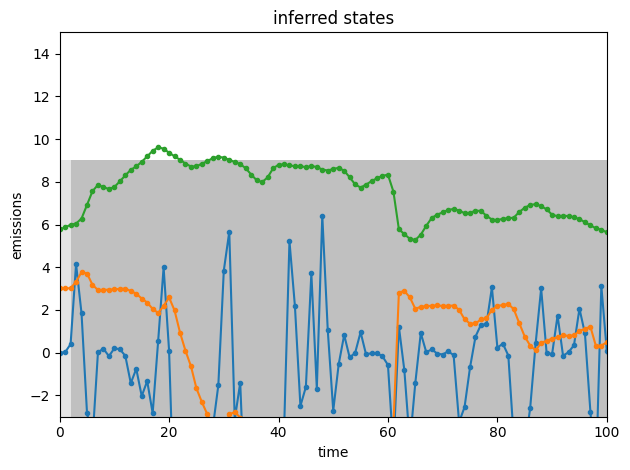

In [ ]:
# Compute the most likely states
most_likely_states = test_hmm.most_likely_states(params, standardized_matrix)

# Compare them to the true states
fig, axs = plt.subplots(1, 1, sharex=True)

for i, states in enumerate([most_likely_states]):
    offsets = 3 * jnp.arange(emission_dim)
    axs.imshow(
        states[None, :],
        extent=(0, num_timesteps, -3, 3 * emission_dim),
        aspect="auto",
        cmap="Greys",
        alpha=0.25)
    axs.plot(standardized_matrix + offsets, '-', marker='.')
    axs.set_xlim(0, num_timesteps)
    axs.set_ylim(-3, 3 * emission_dim)
    axs.set_ylim(-3,15)
    axs.set_ylabel("emissions")
    axs.set_xlabel("time")
    axs.set_xlim(0, 100)

axs.set_title("inferred states")
plt.tight_layout()


In [ ]:
# Find best fold (this is what Zoe does) results
use_fold = np.where(val_lls==np.max(val_lls))[0][0]
use_train = jnp.concatenate([train_emissions[:use_fold-1], train_emissions[use_fold:]])

use_val = train_emissions[use_fold]
print(use_fold)

4


### Train new model on the data from best fold

In [ ]:
# Initialize new hmm
new_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
params, props = new_hmm.initialize(key=jr.PRNGKey(0), method="kmeans", emissions=use_train)
# Fit model to train data
fit_params, train_lps = new_hmm.fit_em(params, props, use_train, 
                                        num_iters=num_iters, verbose=False)
# Get state estimates for validation data
most_likely_states = new_hmm.most_likely_states(fit_params, use_val)
# Pad states array to have the same size as the whole data
complete_most_likely_states = np.concatenate([np.zeros(len(use_val)*(use_fold))* np.nan, most_likely_states, np.zeros(len(use_val)*(4-use_fold))* np.nan]) # hard-coded for now
# Compute log likelihood on the validation data
lls = new_hmm.marginal_log_prob(fit_params, use_val)

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Alternatively used the parameters from the best fit to get most likely states on the whole training set; no retraining

In [ ]:
# Find parameters for best fold
initial_probs = fit_params[0].probs[use_fold]
transition_matrix = fit_params[1].transition_matrix[use_fold]
emission_means = fit_params[2].means[use_fold]
emission_covs = fit_params[2].covs[use_fold]

In [ ]:
# Initialize new hmm
new_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
best_fold_params, props = new_hmm.initialize(key=jr.PRNGKey(0), method="kmeans", initial_probs=initial_probs,
                                transition_matrix=transition_matrix,
                                emission_means=emission_means,
                                emission_covariances=emission_covs,
                                emissions=training_set)  # not sure if I need to include  

# Get state estimates for validation data
most_likely_states = new_hmm.most_likely_states(best_fold_params, training_set)

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Plot the marginal log probs across EM iterations
plt.plot(train_lps)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")
# Use fitted model for posterior inference
post = new_hmm.smoother(params, standardized_matrix[0])
print(post.smoothed_probs.shape) # (1000, 3)

NameError: name 'train_lps' is not defined

#### Plot occupancy of states on validation data

Text(0, 0.5, 'Number of bins')

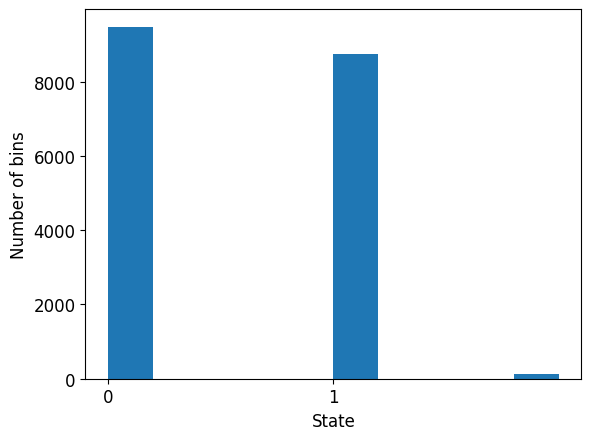

In [ ]:
plt.hist(most_likely_states)
plt.xlabel('State')
plt.xticks(np.arange(0, np.max(most_likely_states), 1), np.arange(0, np.max(most_likely_states), 1))
plt.ylabel('Number of bins')

#### Plot states per event and split per side or correct incorrect

/tmp/ipykernel_17970/1860137500.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


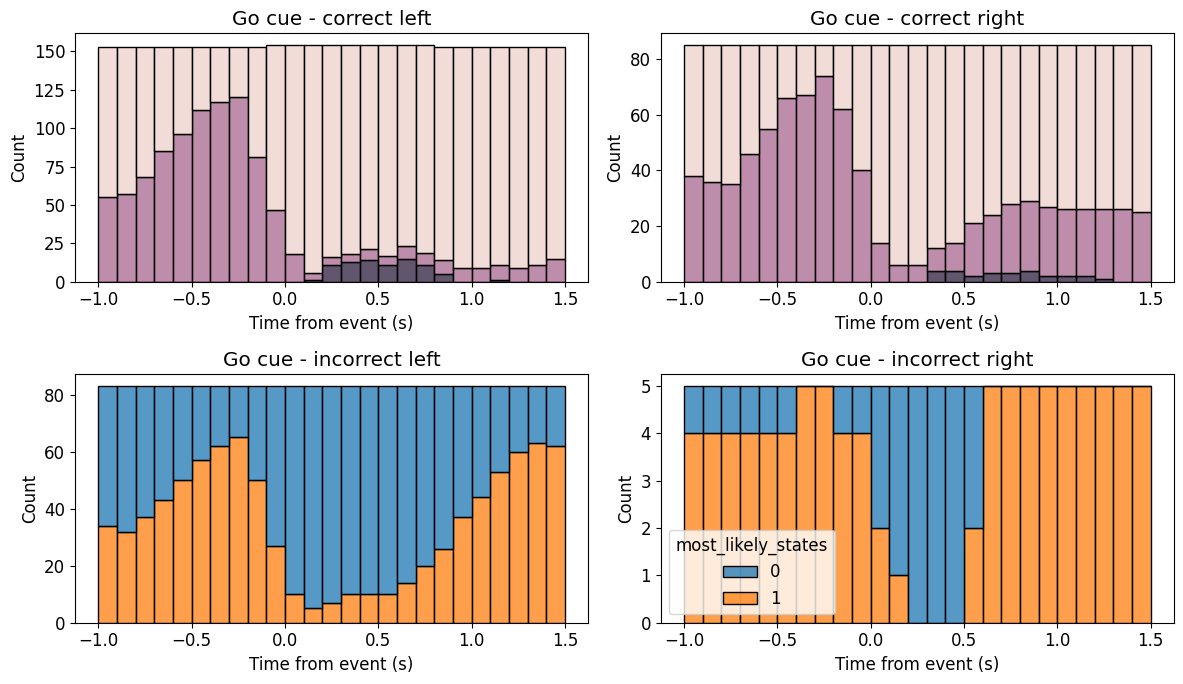

/tmp/ipykernel_17970/1860137500.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


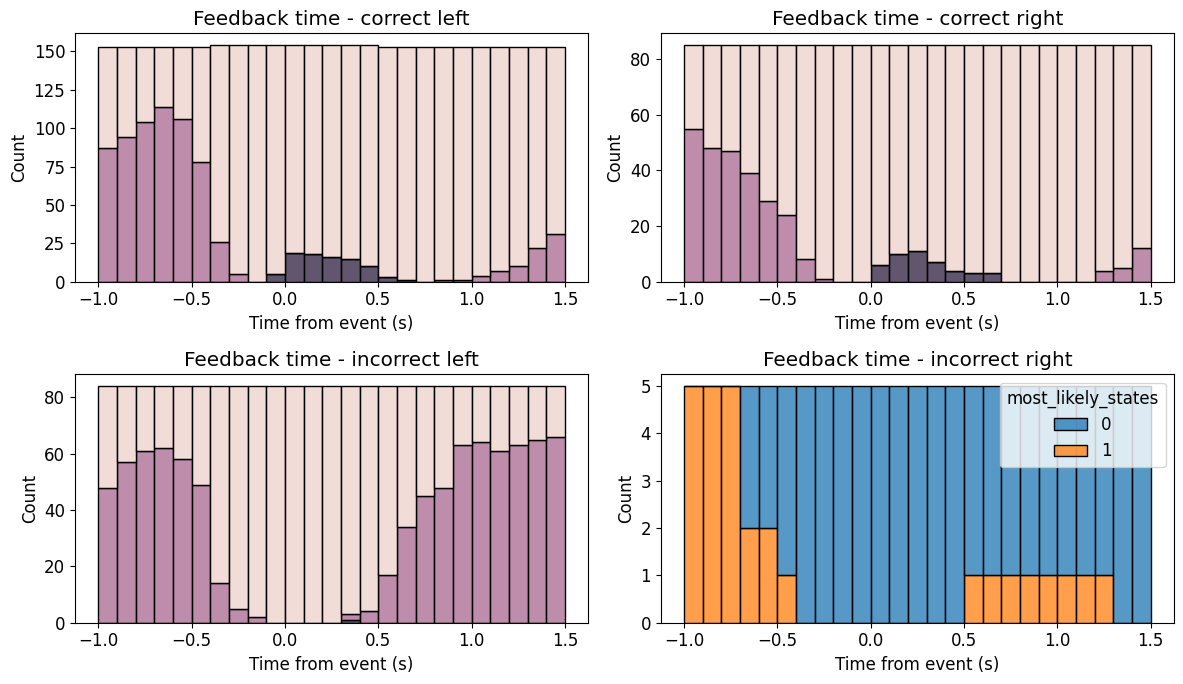

/tmp/ipykernel_17970/1860137500.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


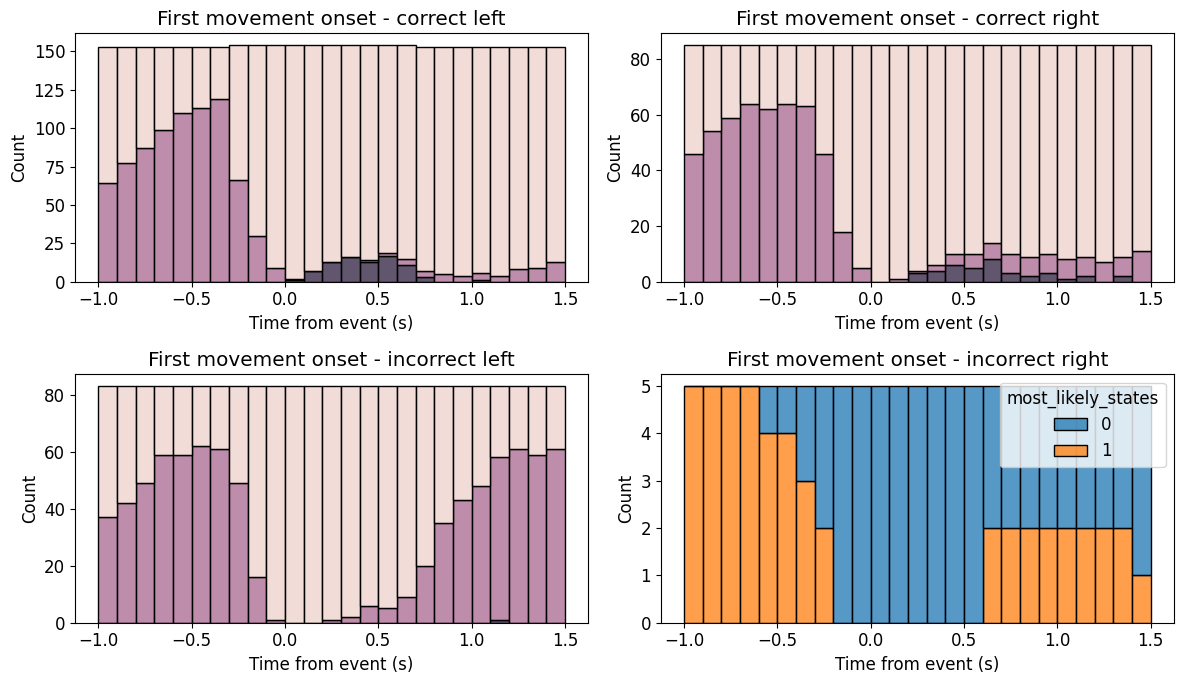

In [ ]:
bin_size = 0.1
multiplier = 1/bin_size

init = -10
end = 15

event_type_list = ['goCueTrigger_times', 'feedback_times', 'firstMovement_times']
event_type_name = ['Go cue', 'Feedback time', 'First movement onset']

# TODO: turn into a function
for e, this_event in enumerate(event_type_list):
    
    # Initialize variables
    #reduced_design_matrix = design_matrix[:num_timesteps // num_train_batches * num_train_batches]
    #reduced_design_matrix = reduced_design_matrix[len(use_val)*use_fold:len(use_val)*(use_fold+1)]
    reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])
    reduced_design_matrix['most_likely_states'] = most_likely_states
    reduced_design_matrix['new_bin'] = reduced_design_matrix['Bin'] * 0
    reduced_design_matrix['correct'] = reduced_design_matrix['Bin'] * 0
    reduced_design_matrix['choice'] = reduced_design_matrix['Bin'] * 0
    
    #test_bin_init = 
    
    events = session_trials[this_event]
    feedback = session_trials['feedbackType']
    choice = session_trials['choice']
    
    events = session_trials[this_event]
    state_stack = np.zeros((len(events), end + init)) * np.nan
            
    for t, trial in enumerate(events[:-2]):
        event = events[t]
        
        # Check feedback
        if feedback[t] ==1:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'correct'] = 1
        elif feedback[t] == 0:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'correct'] = 0
        # Check choice
        if choice[t] ==1:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'choice'] = 'right'
        elif choice[t] == -1:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'choice'] = 'left'
        # Rename bins so that they are aligned on stimulus onset
        if event > 0:
            event_window = reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) & (reduced_design_matrix['Bin']> event*multiplier + init)]
            onset_bin = reduced_design_matrix.loc[reduced_design_matrix['Bin']>= event*multiplier, 'Bin']
            if (len(event_window)>0): # & len(onset_bin)>0:
                bin = list(onset_bin)[0]
                reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'new_bin'] = reduced_design_matrix.loc[(reduced_design_matrix['Bin']< event*multiplier + end) & 
                                        (reduced_design_matrix['Bin']>= event*multiplier + init), 'Bin'] - bin
            else:
                reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) & (reduced_design_matrix['Bin']> event*multiplier + init), 'new_bin'] = np.nan
        else:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) & (reduced_design_matrix['Bin']> event*multiplier + init), 'new_bin'] = np.nan
            
    # PLOT
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=[12, 7])
    plt.rc('font', size=12)
    use_data = reduced_design_matrix.dropna()
    use_data['new_bin'] = use_data['new_bin'] * bin_size
    #use_data = use_data[:test_length*2]
    
    # Correct left
    a = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==1) 
                                                                              & (use_data['choice']=='left')], stat='count', 
                     multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), legend=False, ax = ax[0, 0])
    # Correct right
    b = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==1) 
                                                                              & (use_data['choice']=='right')], stat='count', 
                     multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), legend=False, ax = ax[0, 1])
    # Incorrect left
    c = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==0) 
                                                                              & (use_data['choice']=='left')], stat='count',
                     multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), legend=False, ax = ax[1, 0])
    # Incorrect right
    d = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==0) 
                                                                              & (use_data['choice']=='right')], 
                     stat='count', multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), ax = ax[1, 1])
    
    ax[0, 0].set_title(str(event_type_name[e] + ' - correct left'))
    ax[0, 0].set_xlabel(str('Time from event (s)'))

    ax[0, 1].set_title(str(event_type_name[e] + ' - correct right'))
    ax[0, 1].set_xlabel(str('Time from event (s)'))
    
    ax[1, 0].set_title(str(event_type_name[e] + ' - incorrect left'))
    ax[1, 0].set_xlabel(str('Time from event (s)'))
    
    ax[1, 1].set_title(str(event_type_name[e] + ' - incorrect right'))
    ax[1, 1].set_xlabel(str('Time from event (s)'))
    #sns.move_legend(d, "upper left", bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

### Plot for only the best fold

In [ ]:
bin_size = 0.1
multiplier = 1/bin_size

init = -10
end = 15

event_type_list = ['goCueTrigger_times', 'feedback_times', 'firstMovement_times']
event_type_name = ['Go cue', 'Feedback time', 'First movement onset']

for e, this_event in enumerate(event_type_list):
    
    # Initialize variables
    #reduced_design_matrix = design_matrix[:num_timesteps // num_train_batches * num_train_batches]
    reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])
    reduced_design_matrix = reduced_design_matrix[len(use_val)*use_fold:len(use_val)*(use_fold+1)]
    reduced_design_matrix['most_likely_states'] = most_likely_states
    reduced_design_matrix['new_bin'] = reduced_design_matrix['Bin'] * 0
    reduced_design_matrix['correct'] = reduced_design_matrix['Bin'] * 0
    reduced_design_matrix['choice'] = reduced_design_matrix['Bin'] * 0
    
    events = session_trials[this_event]
    feedback = session_trials['feedbackType']
    choice = session_trials['choice']
    state_stack = np.zeros((len(events), end + init)) * np.nan
            
    for t, trial in enumerate(events[2:-2]):
        event = events[t]
        
        # Check feedback
        if feedback[t] ==1:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'correct'] = 1
        elif feedback[t] == 0:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'correct'] = 0
        # Check choice
        if choice[t] ==1:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'choice'] = 'right'
        elif choice[t] == -1:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'choice'] = 'left'
        # Rename bins so that they are aligned on stimulus onset
        if event > 0:
            event_window = reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) & (reduced_design_matrix['Bin']> event*multiplier + init)]
            onset_bin = reduced_design_matrix.loc[reduced_design_matrix['Bin']>= event*multiplier, 'Bin']
            if (len(event_window)>0 ):  # & len(onset_bin)>0
                bin = list(onset_bin)[0]
                reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) &
                                        (reduced_design_matrix['Bin']> event*multiplier + init), 
                                        'new_bin'] = reduced_design_matrix.loc[(reduced_design_matrix['Bin']< event*multiplier + end) & 
                                        (reduced_design_matrix['Bin']>= event*multiplier + init), 'Bin'] - bin
            else:
                reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) & (reduced_design_matrix['Bin']> event*multiplier + init), 'new_bin'] = np.nan
        else:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*multiplier + end) & (reduced_design_matrix['Bin']> event*multiplier + init), 'new_bin'] = np.nan

    # PLOT

    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=[12, 7])
    plt.rc('font', size=12)
    use_data = reduced_design_matrix.dropna()
    use_data['new_bin'] = use_data['new_bin'] * bin_size
    
    # Correct left
    a = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==1) 
                                                                              & (use_data['choice']=='left')], stat='count', 
                     multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), legend=False, ax = ax[0, 0])
    # Correct right
    b = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==1) 
                                                                              & (use_data['choice']=='right')], stat='count', 
                     multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), legend=False, ax = ax[0, 1])
    # Incorrect left
    c = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==0) 
                                                                              & (use_data['choice']=='left')], stat='count',
                     multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), legend=False, ax = ax[1, 0])
    # Incorrect right
    d = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==0) 
                                                                              & (use_data['choice']=='right')], 
                     stat='count', multiple="stack", binwidth=bin_size, binrange=(bin_size*init, bin_size*end), ax = ax[1, 1])
    
    ax[0, 0].set_title(str(event_type_name[e] + ' - correct left'))
    ax[0, 0].set_xlabel(str('Time from event (s)'))

    ax[0, 1].set_title(str(event_type_name[e] + ' - correct right'))
    ax[0, 1].set_xlabel(str('Time from event (s)'))
    
    ax[1, 0].set_title(str(event_type_name[e] + ' - incorrect left'))
    ax[1, 0].set_xlabel(str('Time from event (s)'))
    
    ax[1, 1].set_title(str(event_type_name[e] + ' - incorrect right'))
    ax[1, 1].set_xlabel(str('Time from event (s)'))
    #sns.move_legend(d, "upper left", bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_62947/3318351614.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_design_matrix = design_matrix[:test_length*2].append(design_matrix[-test_length*2:])


IndexError: list index out of range

### Plot predictors overlayed with states

NameError: name 'complete_most_likely_states' is not defined

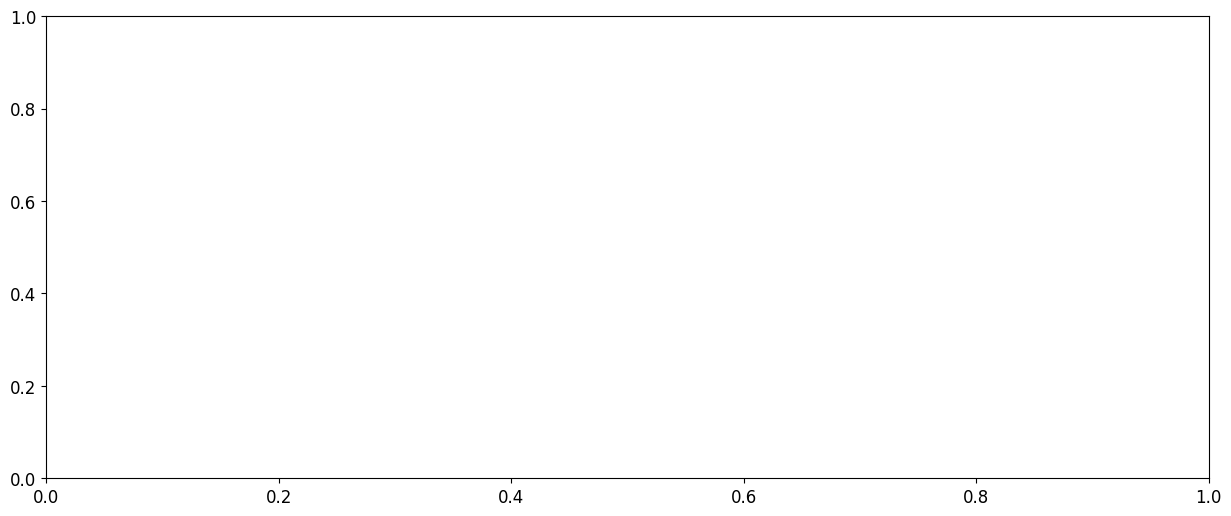

In [ ]:
# Compute the most likely states
init = 1000 + len(use_val)*(use_fold)
end = 1200 + len(use_val)*(use_fold)

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(15, 6))

#axs.imshow(
#    complete_most_likely_states[None,:], 
#    extent=(0, len(complete_most_likely_states), np.min(use_val) -.5, np.max(use_val) + .5),
#    aspect="auto",
#    cmap="Greys",
#    alpha=0.25) #extent=(0, end-init, np.min(test_set) -.5, np.max(test_set) + .5),

axs.imshow(
    complete_most_likely_states[None,:], 
    extent=(0, len(complete_most_likely_states), np.min(use_val) -.5, np.max(use_val) + .5),
    aspect="auto",
    cmap="Greys",
    alpha=0.25) #extent=(0, end-init, np.min(test_set) -.5, np.max(test_set) + .5),

axs.vlines(np.array(session_trials['goCueTrigger_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='Stim On', color='Black')
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='Correct', color='Green')
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='Incorrect', color='Red')
#axs.vlines(np.array(session_trials['firstMovement_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='First movement', color='Blue')
axs.hlines(0, init, end, color='Gray', linewidth=.5)

# Plot original values
axs.plot(design_matrix['Bin'], design_matrix['whisker_me'], label='Whisker ME')
axs.plot(design_matrix['Bin'], design_matrix['nose_speed_X'], label='Nose speed')
axs.plot(design_matrix['Bin'], design_matrix['Gaussian_licks'], label='Licks')

axs.set_ylim(np.min(use_val) -.5, np.max(use_val) + .5)
axs.set_ylim(-7.5, 7.5)

axs.set_ylabel("emissions")
axs.set_xlabel("time (s)")
axs.set_xlim(init, end)
axs.set_xticks(np.arange(init, end+50, 50),np.arange(init/10, end/10+5, 5))

axs.set_title("inferred states")
plt.legend()
plt.tight_layout()

KeyError: 'whisker_me'

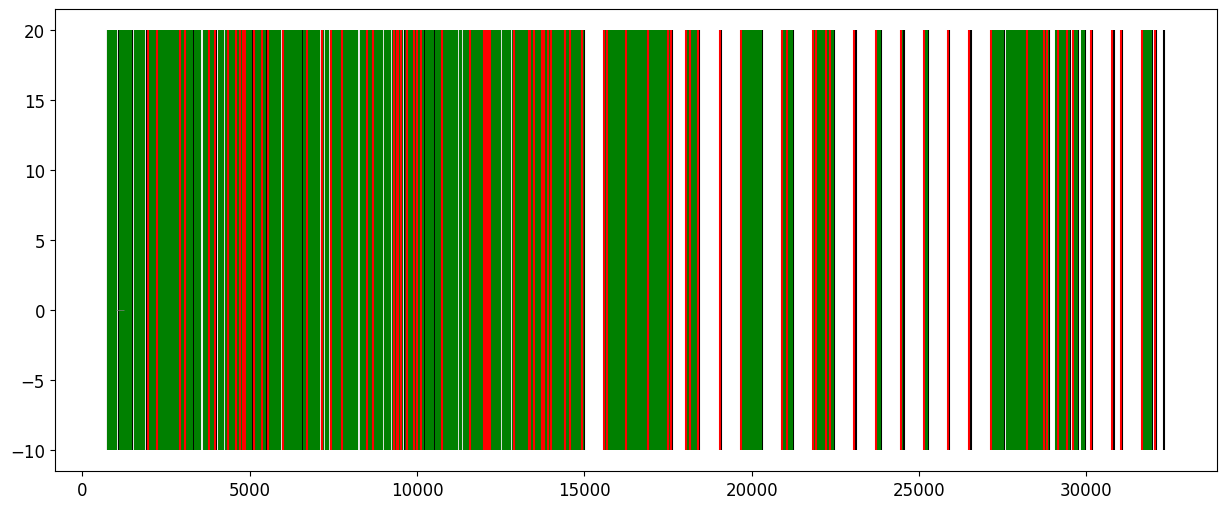

In [ ]:
# Compute the most likely states
#init = 1000 + len(use_val)*(use_fold-1)
#end = 1500 + len(use_val)*(use_fold-1)

init = 1000
end = 1250

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(15, 6))

axs.vlines(np.array(session_trials['goCueTrigger_times'] * 10), -10, 20, label='Stim On', color='Black')
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 10), -10, 20, label='Correct', color='Green')
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * 10), -10, 20, label='Incorrect', color='Red')
#axs.vlines(np.array(session_trials['firstMovement_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='First movement', color='Blue')
axs.hlines(0, init, end, color='Gray', linewidth=.5)

# Plot original values
#axs.plot(design_matrix['Bin'], design_matrix['pupil_diameter'], label='Pupil diameter')
#axs.plot(design_matrix['Bin'], design_matrix['avg_wheel_vel'], label='Wheel velocity')
axs.plot(design_matrix['Bin'], design_matrix['whisker_me'], label='Whisker ME')
axs.plot(design_matrix['Bin'], design_matrix['nose_speed_X'], label='Nose speed')
axs.plot(design_matrix['Bin'], design_matrix['Gaussian_licks'], label='Licks')
#axs.plot(design_matrix['Bin'], design_matrix['r_paw_speed'], label='Right paw speed')
#axs.plot(design_matrix['Bin'], design_matrix['l_paw_speed'], label='Left paw speed')
#axs.plot(design_matrix['Bin'], design_matrix['pupil_speed'], label='Pupil speed')

       
#axs.set_ylim(np.min(use_val) -.5, np.max(use_val) + .5)
axs.set_ylim(-7.5, 20)

axs.set_ylabel("")
axs.set_xlabel("time (s)")
axs.set_xlim(init, end)
axs.set_xticks(np.arange(init, end+50, 50),np.arange(init/10, end/10+5, 5))

axs.set_title("")
plt.legend()
plt.tight_layout()


(14682, 2)


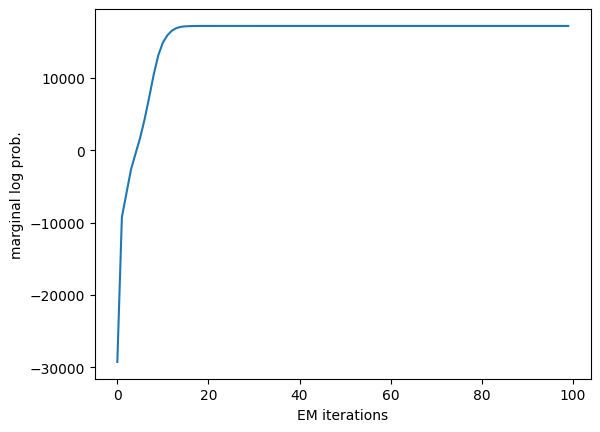

In [ ]:
# Make a Gaussian HMM and sample data from it
hmm = GaussianHMM(num_states, emission_dim, transition_matrix_concentration=1)
#true_params, _ = hmm.initialize(key1)
#true_states, emissions = hmm.sample(true_params, key2, num_timesteps)

# Make a new Gaussian HMM and fit it with EM
params_init, props = hmm.initialize(key3, method="kmeans", emissions=standardized_matrix)
params, lls = hmm.fit_em(params_init, props, standardized_matrix, num_iters=100)

# Plot the marginal log probs across EM iterations
plt.plot(lls)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")

# Use fitted model for posterior inference
post = hmm.smoother(params, standardized_matrix)
print(post.smoothed_probs.shape) # (1000, 3)